In [11]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan
plt.rc('font', family='Arial')

from qtrendutils import linfit_utils as linfit
from qtrendutils import shapefile_utils as shp
from qtrendutils import mapplot_utils as mymaps
from qtrendutils import colorbar_utils as cbars
from qtrendutils import lineplot_utils as lineplot
from qtrendutils import calendar_utils as cal
import pandas as pd
import importlib 
importlib.reload(cal)

import warnings
warnings.filterwarnings('ignore')
import sys

In [12]:
dat = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/OBS/vaporpressures/"+
          "vaporpressures_ERA5.nc")

shpfile="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/shp/gadm36_USA_1.shp"
mask = shp.maskgen(shpfile, dat,
   ['California','Nevada','Utah','Arizona','New Mexico','Colorado'])

In [13]:
landfrac = xr.open_dataset("../../DATA_SORT/LANDFRAC_LENS2.nc")
landfrac = landfrac.landfrac
landfrac = landfrac.where(landfrac > 0, nan)
landfrac = landfrac.where(landfrac.lat > -60, nan) # omitting Antarctica

In [14]:
plotpath="/project/cas/islas/python_plots/qtrend_paper/figures/supplemental/"
trendpath="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/"

In [15]:
era5map = xr.open_dataset(trendpath+"vptrends_ERA5_climps.nc")
era5map['lon'] = landfrac['lon'] ; era5map['lat'] = landfrac['lat']

### Read in the Southwest Data

In [16]:
cmip6info = pd.read_csv("/home/islas/python/qtrend_paper/DATA_SORT/CMIP6/cmip6csvinfo.csv")
models = cmip6info['Model']
nmems = cmip6info['Nmem']
nmemmax = np.max(cmip6info['Nmem'])
nmemscmip6 = nmems


basepath="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/"
era5_vp_sw = xr.open_dataset(basepath+'vaporpressures_climps/vaporpressures_ERA5_USSW.nc').sel(time=slice("1980-01-01","2020-12-31"))
cmip6_vp_sw = xr.open_dataset(basepath+'vaporpressures_climps/vaporpressures_CMIP6_USSW.nc').sel(time=slice("1980-01-01","2020-12-31"))
lens2_vp_sw = xr.open_dataset(basepath+'vaporpressures_climps/vaporpressures_LENS2_USSW.nc').sel(time=slice("1980-01-01","2020-12-31"))
goga2_vp_sw = xr.open_dataset(basepath+'vaporpressures_climps/vaporpressures_GOGA2_USSW.nc').sel(time=slice("1980-01-01","2020-12-31"))

era5_vp_sw_am = era5_vp_sw.groupby('time.year').mean('time').sel(year=slice(1980,2020))
cmip6_vp_sw_am = cmip6_vp_sw.groupby('time.year').mean('time').sel(year=slice(1980,2020))
lens2_vp_sw_am = lens2_vp_sw.groupby('time.year').mean('time').sel(year=slice(1980,2020))
goga2_vp_sw_am = goga2_vp_sw.groupby('time.year').mean('time').sel(year=slice(1980,2020))


era5_vp_sw_trend = xr.apply_ufunc(linfit.compute_slope, era5_vp_sw_am, vectorize=True, input_core_dims=[['year']])*era5_vp_sw_am.year.size
cmip6_vp_sw_trend = xr.apply_ufunc(linfit.compute_slope, cmip6_vp_sw_am, vectorize=True, input_core_dims=[['year']])*cmip6_vp_sw_am.year.size
lens2_vp_sw_trend = xr.apply_ufunc(linfit.compute_slope, lens2_vp_sw_am, vectorize=True, input_core_dims=[['year']])*lens2_vp_sw_am.year.size
goga2_vp_sw_trend = xr.apply_ufunc(linfit.compute_slope, goga2_vp_sw_am, vectorize=True, input_core_dims=[['year']])*goga2_vp_sw_am.year.size

nyears = np.int(era5_vp_sw_am.year.size)


In [17]:
def setup_svp_vs_vp(x1, x2, y1, y2, titlestr):
    ax = fig.add_axes([x1, y1, x2-x1, y2-y1])
    ax.plot([0,0],[0,5],color='black')
    ax.set_xlim(-1,2.2)
    ax.set_ylim(0,5.)
    ax.set_xticks([-1,-0.5,0,0.5,1,1.5,2])
    ax.set_xticklabels(['-1','-0.5','0','0.5','1','1.5','2'], fontsize=13)
    ax.set_yticks([0,1,2,3,4,5])
    ax.set_yticklabels(['0','1','2','3','4','5'], fontsize=13)
    ax.set_title(titlestr, fontsize=16)
    ax.set_xlabel('VP trend (hPa/'+str(np.int(nyears))+'y)', fontsize=15)
    ax.set_ylabel('Saturation VP trend (hPa/'+str(np.int(nyears))+'y)', fontsize=15)
    
    x = np.arange(-1,6,1) ; y =np.arange(-1,6,1)
    vpdcontours = np.zeros([y.size, x.size])
    for ix in np.arange(0,x.size,1):
        vpdcontours[:,ix] = y[:] - x[ix]

    CS = ax.contour(x, y, vpdcontours, levels=[-6,-5,-4,-3,-2,-1,0,1,2,3,4,5], colors='lightgray')
    ax.clabel(CS, CS.levels, inline=True, fmt='%1.1f', fontsize=10)   
         
    return ax

In [18]:
cmip6colors=['rosybrown','lightcoral','indianred','firebrick','maroon','red','chocolate','saddlebrown','sandybrown','peachpuff','tan',
             'darkgoldenrod','gold','darkkhaki',
             'olive','yellowgreen','darkolivegreen','darkseagreen','palegreen','forestgreen','mediumseagreen','mediumaquamarine',
             'turquoise','lightseagreen','teal','cadetblue','powderblue','steelblue','dodgerblue','blue','slateblue','darkslateblue',
             'blueviolet','indigo','mediumorchid','plum','violet','purple','palevioletred','magenta','crimson','lightpink']

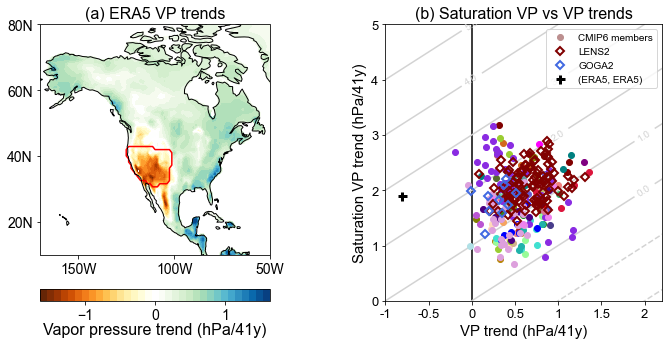

In [19]:
import importlib
importlib.reload(mymaps)

fig = plt.figure(figsize=(16,16))

#------ERA5 map
ax = mymaps.contourmap_northamerica_fill_pos(fig, era5map.vp*landfrac, era5map.lon, era5map.lat,0.1,-1.6,1.6,'(a) ERA5 VP trends',
                                           0.05,0.25,0.8,1,cmap='precip', fontsize=16)
ax = plt.contour(mask.lon, mask.lat, np.nan_to_num(mask), levels=[0,1], colors='red', linewidth=2)
#---------------

ax = cbars.plotcolorbar(fig, 0.1, -1.6, 1.6,'Vapor pressure trend (hPa/41y)', 0.05,0.25,0.76,0.77,cmap='precip')

ax = setup_svp_vs_vp(0.35,0.59,0.76,1,'(b) Saturation VP vs VP trends')

for imodel in np.arange(0,cmip6_vp_sw_trend.model.size,1):
    datx = cmip6_vp_sw_trend.vp.isel(model=imodel)
    daty = cmip6_vp_sw_trend.svp.isel(model=imodel)
    datx = datx.sel(member=slice(1,nmems[imodel]))
    daty = daty.sel(member=slice(1,nmems[imodel]))
    ax.plot(datx, daty, "o", markersize=6, color=cmip6colors[imodel], label='CMIP6 members' if imodel == 0 else "")

ax.plot(lens2_vp_sw_trend.vp, lens2_vp_sw_trend.svp,"D", color='maroon', markerfacecolor='None', markersize=6, markeredgewidth=2,
       label='LENS2')
ax.plot(goga2_vp_sw_trend.vp, goga2_vp_sw_trend.svp,"D", color='royalblue', markerfacecolor='None', markersize=6, markeredgewidth=2,
       label='GOGA2')

ax.plot(era5_vp_sw_trend.vp, era5_vp_sw_trend.svp,"+", markerfacecolor='black', markersize=9,markeredgecolor='black', 
        markeredgewidth=3, label='(ERA5, ERA5)')    

ax.legend(loc='upper right')

fig.savefig(plotpath+'figS3.pdf', bbox_inches='tight', facecolor='white')